In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import typing as tp

import arch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from ovm.bootstrap import (
    convert_block_lenghts_to_seconds, 
    convert_block_length_from_seconds_to_blocks, 
    estimate_optimal_block_lengths_for_multiple_price_series, 
    estimate_optimal_block_lengths_in_seconds_for_multiple_price_series
)
    
from ovm.historical_data_io import (
    PriceHistoryColumnNames as PHCN, 
    compute_number_of_days_in_price_history, 
    compute_log_returns_from_price_history, 
    save_price_histories, 
    load_price_history, 
    load_price_histories, 
    construct_series_name_to_closing_price_map, 
    construct_closing_price_df, 
    compute_log_return_df
)

from ovm.utils import TimeResolution

In [3]:
from recombinator import (
    stationary_bootstrap, 
    tapered_block_bootstrap
)

from recombinator.optimal_block_length import optimal_block_length

In [4]:
%matplotlib inline

In [5]:
# price_history = \
#         load_price_history(filename=price_history_file_name,
#                            series_name=price_history_file_name,
#                            directory_path=directory_path,
#                            period_length_in_seconds=time_resolution.in_seconds)# def adf_test(timeseries):
# #     print ('Results of Dickey-Fuller Test:')
# #     dftest = adfuller(timeseries, autolag='AIC')
# #     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# #     for key,value in dftest[4].items():
# #        dfoutput['Critical Value (%s)'%key] = value
# #     print (dfoutput)

In [6]:
time_resolution = TimeResolution.FIFTEEN_MINUTES
directory_path = time_resolution.value

In [7]:
series_names = \
    ['BTC-USD', 
     'ETH-USD', 
     'AAVE-USD', 
     'YFI-USD', 
     'UNI-USD', 
     'BAL-USD', 
     'COMP-USD', 
     'LINK-USD', 
     'CREAM-USD', 
     'SUSHI-USD' ]

In [8]:
# series_name_to_price_history_map = \
#     {series_name: load_price_history(filename=series_name, 
#                                      series_name=series_name, 
#                                      directory_path=directory_path, 
#                                      period_length_in_seconds=time_resolution.in_seconds)
#      for series_name in series_names}
series_name_to_price_history_map = \
    load_price_histories(series_names=series_names, 
                         period_length_in_seconds=time_resolution.in_seconds, 
                         directory_path=time_resolution.value)

In [9]:
series_name_to_data_length_map = \
    {series_name: len(price_history.price_history_df)
     for series_name, price_history 
     in series_name_to_price_history_map.items()}
series_name_to_data_length_map

{'BTC-USD': 47353,
 'ETH-USD': 42052,
 'AAVE-USD': 4308,
 'YFI-USD': 11873,
 'UNI-USD': 6702,
 'BAL-USD': 14761,
 'COMP-USD': 15360,
 'LINK-USD': 21010,
 'CREAM-USD': 7330,
 'SUSHI-USD': 8261}

In [10]:
selected_series_names = \
    ['BTC-USD', 
     'ETH-USD', 
     'YFI-USD', 
     'BAL-USD', 
     'COMP-USD', 
     'LINK-USD']

In [11]:
# series_name_to_optimal_block_length_map = \
#     {series_name: optimal_block_length(price_history.unscaled_log_returns.values) 
#      for series_name, price_historyhttps://github.com/InvestmentSystems/recombinator.git
#      in tqdm(series_name_to_price_history_map.items())}
series_name_to_optimal_block_length_map = \
    estimate_optimal_block_lengths_for_multiple_price_series(series_name_to_price_history_map)

100%|██████████| 10/10 [00:00<00:00, 31.40it/s]


In [12]:
# series_name_to_block_lengths_in_seconds_map = \
#     {series_name: obl[0].b_star_sb * time_resolution.in_seconds
#      for series_name, obl 
#      in series_name_to_optimal_block_length_map.items()}
# series_name_to_block_lengths_in_seconds_map
# series_name_to_block_lengths_in_seconds_map = \
#     estimate_optimal_block_lengths_in_seconds_for_multiple_price_series(
#         series_name_to_price_history_map=series_name_to_price_history_map, 
#         period_length_in_seconds=time_resolution.in_seconds)
# series_name_to_block_lengths_in_seconds_map
series_name_to_block_lengths_in_seconds_map = \
    convert_block_lenghts_to_seconds(series_name_to_optimal_block_length_map, 
                                     period_length_in_seconds=time_resolution.in_seconds)
series_name_to_block_lengths_in_seconds_map

{'BTC-USD': 53805.20232678347,
 'ETH-USD': 25813.264459000082,
 'AAVE-USD': 2390.547686238729,
 'YFI-USD': 1742.7813342914674,
 'UNI-USD': 3372.5955728885147,
 'BAL-USD': 5821.908768821018,
 'COMP-USD': 26408.615697511766,
 'LINK-USD': 10629.986144578435,
 'CREAM-USD': 3024.6533849087496,
 'SUSHI-USD': 1512.9629972802327}

In [13]:
max_optimal_block_length_in_seconds_for_selected_series = \
    max(block_lengths_in_seconds 
        for series_name, block_lengths_in_seconds 
        in series_name_to_block_lengths_in_seconds_map.items() 
        if series_name in selected_series_names)
max_optimal_block_length_in_seconds_for_selected_series

53805.20232678347

In [14]:
# series_name_to_closing_price_map = \
#     {series_name: price_history.price_history_df.loc[:, PHCN.CLOSE]
#      for series_name, price_history
#      in tqdm(series_name_to_price_history_map.items())}
series_name_to_closing_price_map = \
    construct_series_name_to_closing_price_map(series_name_to_price_history_map)

In [15]:
df = pd.DataFrame(data=series_name_to_closing_price_map)

In [16]:
df.head()

,BTC-USD,ETH-USD,AAVE-USD,YFI-USD,UNI-USD,BAL-USD,COMP-USD,LINK-USD,CREAM-USD,SUSHI-USD
start_time,,,,,,,,,,
1563714000000,10542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563714900000,10584.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563715800000,10568.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563716700000,10535.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563717600000,10531.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.diff()

,BTC-USD,ETH-USD,AAVE-USD,YFI-USD,UNI-USD,BAL-USD,COMP-USD,LINK-USD,CREAM-USD,SUSHI-USD
start_time,,,,,,,,,,
1563714000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563714900000,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563715800000,-16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563716700000,-32.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563717600000,-4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1606341600000,0.0,-1.55,-0.45,-305.0,-0.033,-0.3975,-0.66,-0.1095,0.05,-0.0047
1606342500000,-58.0,-6.09,-0.82,-275.0,-0.037,-0.3275,-2.05,-0.1210,-0.40,-0.0231
1606343400000,-90.5,-5.31,-0.54,-105.0,-0.062,-0.0125,-0.45,-0.2555,-0.05,-0.0329


In [18]:
len(np.log(df).diff())

47354

In [19]:
log_return_df = \
    compute_log_return_df(
        construct_closing_price_df(
            construct_series_name_to_closing_price_map(series_name_to_price_history_map)))
log_return_df.head()

,BTC-USD,ETH-USD,AAVE-USD,YFI-USD,UNI-USD,BAL-USD,COMP-USD,LINK-USD,CREAM-USD,SUSHI-USD
start_time,,,,,,,,,,
1563714000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563714900000,0.003976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563715800000,-0.001513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563716700000,-0.003080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563717600000,-0.000427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
selected_log_return_df = log_return_df.loc[:, selected_series_names].dropna()

In [21]:
len(selected_log_return_df)

11871

Block Bootstrap. The shape of the output array is  
(number of monte carlo replications, length of simulated time series, number of cryptocurrencies simulated)  

The order of the cryptocurrencies on the last axis corresponds to the sequence `selected_series_names`

In [22]:
block_length = \
    convert_block_length_from_seconds_to_blocks(max_optimal_block_length_in_seconds_for_selected_series, 
                                                period_length_in_seconds=time_resolution.in_seconds)

bootstrap_log_returns = \
    stationary_bootstrap(
        selected_log_return_df.values, 
        block_length=block_length, 
        replications=1)

bootstrap_log_returns.shape

(1, 11871, 6)

In [23]:
# plt.plot(bootstrap_log_returns.squeeze())

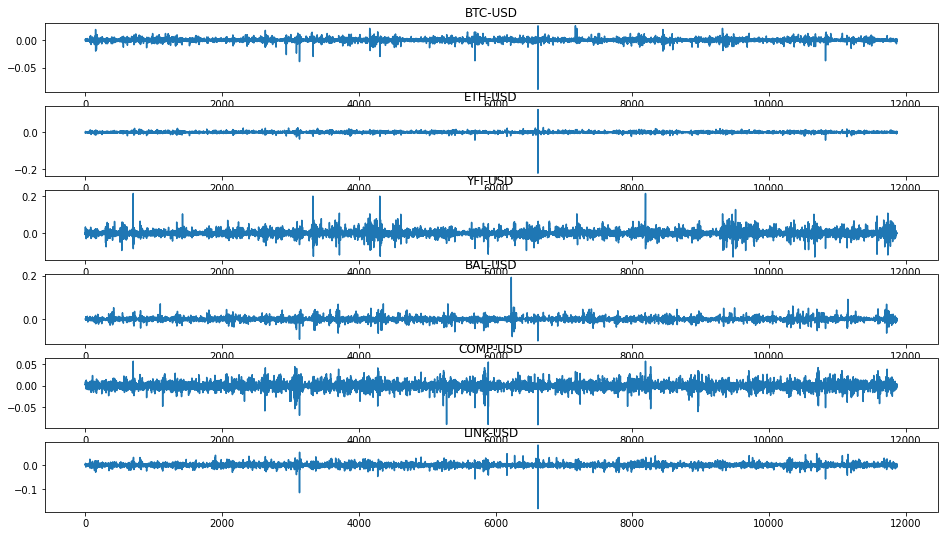

In [24]:
fig, axs = plt.subplots(bootstrap_log_returns.shape[-1], figsize=(16, 9))
for i, series_name in enumerate(selected_series_names):
    axs[i].plot(bootstrap_log_returns[0, :, i])
    axs[i].set_title(series_name)